In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt

from collections import defaultdict

import my_graph_helpers as mgh
import my_graph as mg
import numpy as np
import networkx as nx

import itertools

In [35]:
reload(mg)
reload(mgh)

<module 'my_graph_helpers' from 'my_graph_helpers.pyc'>

In [3]:
simpleG = mgh.testGraphLattice(8)
simpleG.name = "L0"
simpleduals= simpleG.stacked_duals()
i = simpleG.trace_faces()

In [16]:
myG = mgh.testGraphLattice(9)
myG.name = "S0"

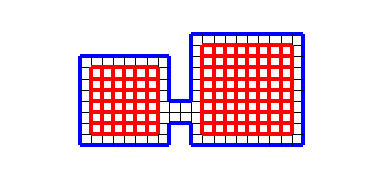

In [17]:
G2 = mgh.testGraphLattice(11,xshift=10,yshift=0)
G3 = mgh.testGraphLattice(3,xshift=8,yshift=2)
myGG = mg.MyGraph(nx.compose_all([myG.G, G2.G, G3.G]))

disconnect = myGG.clean_up_geometry(0.5, connected=True)
disconnect.plot_roads(update=True)

myG=disconnect

10

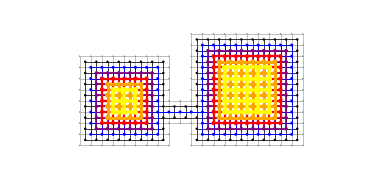

In [18]:
duals = myG.stacked_duals()

myG.plot_weak_duals(duals[0:7])

len(duals)

In [46]:
filename = "data/CapeTown"
place = "cape"
erezero = np.array([305680, 8022350])
crezero= np.array([-31900, -3766370])
original = mgh.import_and_setup(0, filename, rezero=crezero,
                                threshold=1, connected=False,
                                name=place+"_S0")

cape = original.copy()
capeduals = cape.stacked_duals()

data loaded


In [80]:
def S1_nodes(G):
    for f in G.inner_facelist:
        f.odd_node[1] = f.centroid
        
def listoffaces(G, depth):
    is_odd = bool(depth % 2)
    
    try:
        assert is_odd
    except AssertionError:
        raise RuntimeError("depth ({}) should be odd".format(depth))
    
    flist = [f for f in G.inner_facelist if (depth in f.odd_node and f.odd_node[depth])]
    return flist

"""Basically, this function finds all the faces in S1 that overlap each face in S0, 
and then maps those into the nodes in S2, giving us a mapping for a face in S0 to a face
in S2. 'down2_nodes' is the set of nodes in dual1 which make up the centriods 
of the faces in dual1 that are shared with the centroid of face0.     """   

def two_levels(myG, depth, dual1, dual2):
    flist = listoffaces(myG,depth-1)
    
    dual1_faces = [f for G in dual1 for f in G.inner_facelist]
    dual2_faces = [f for G in dual2 for f in G.inner_facelist]
    
    # finds even level nodes (at depth)
    for face0 in flist:
        down2_nodes = []
        face0.even_nodes[depth] = None
        for face1 in dual1_faces:
            if face0.odd_node[depth-1] in face1.nodes:
                down2_nodes.append(face1.centroid)
                face0.even_nodes[depth] = set(down2_nodes)

    # finds odd level nodes (at depth+1)    
    for face0 in flist:
        face0.odd_node[depth+1] = None
        for face2 in dual2_faces:
            if set(face0.even_nodes[depth]) == set(face2.nodes):
                face0.odd_node[depth+1] = face2.centroid        



In [51]:
def formClass2(myG, duals, depth, result):
    dm1 = depth - 1
    dp1 = depth + 1
    
    is_odd = bool(depth % 2)
    
    try:
        assert not is_odd
    except AssertionError:
        raise RuntimeError("depth ({}) should be even".format(depth))  

    flist = [f for f in myG.inner_facelist if (dm1 in f.odd_node and f.odd_node[dm1])]
    
    dual1 = duals[dm1]
    dual2 = duals[depth]
    
    dual1_faces = [f for G in dual1 for f in G.inner_facelist]
    dual2_faces = [f for G in dual2 for f in G.inner_facelist]
    
    # finds even level nodes
    for face0 in flist:
        down2_nodes = []
        #face0.even_nodes[depth] = None
        for face1 in dual1_faces:
            if face0.odd_node[depth-1] in face1.nodes:
                down2_nodes.append(face1.centroid)
                face0.even_nodes[depth] = set(down2_nodes)

    # finds odd level nodes     
    for face0 in flist:
        #face0.odd_node[depth+1] = None
        if depth in face0.even_nodes:
            for face2 in dual2_faces:
                if set(face0.even_nodes[depth]) == set(face2.nodes):
                    face0.odd_node[depth+1] = face2.centroid
    
    result[depth+1] = [f for f in myG.inner_facelist 
                       if depth+1 in f.odd_node and f.odd_node[depth+1]]
    
    depth = depth + 2
    return myG, duals, depth, result
    

In [52]:
def formClass(myG, duals, depth, result):
    
    two_levels(myG, depth, duals[depth-1], duals[depth])
    
    result[depth+1] = [f for f in myG.inner_facelist 
                       if depth+1 in f.odd_node and f.odd_node[depth+1]]
    
    depth = depth + 2
    return myG, duals, depth, result


def form_equivalence_classes(myG):
    
    duals = myG.stacked_duals()

    depth = 1
    result = {}
    
    S1_nodes(myG)
    result[depth] = [f for f in myG.inner_facelist if f.odd_node[depth]]
    depth += 1
    
    while depth < len(duals):
        myG, duals,depth, result = formClass2(myG,duals,depth,result)
        print "current depth {} just finished".format(depth)
        print "Graph S{} has {} parcels".format(depth-1, len(result[depth-1]))
        
    return result, depth

In [60]:
result, depth = form_equivalence_classes(cape)

current depth 4 just finished
Graph S3 has 389 parcels
current depth 6 just finished
Graph S5 has 227 parcels
current depth 8 just finished
Graph S7 has 102 parcels
current depth 10 just finished
Graph S9 has 33 parcels


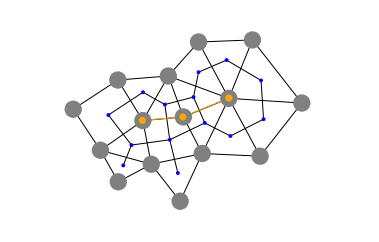

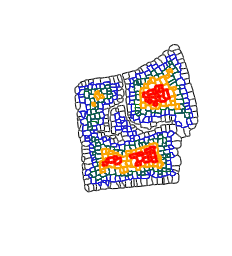

In [59]:

myResult1 = mgh.graphFromMyFaces(result[1])

myResult3 = mgh.graphFromMyFaces(result[3])

myResult5 = mgh.graphFromMyFaces(result[5])

myResult7 = mgh.graphFromMyFaces(result[7])

myResult9 = mgh.graphFromMyFaces(result[9])

cape.plot(node_size = 1, node_color= "grey")
myResult3.plot(node_size = 1, node_color = "blue", width = 1, edge_color = "blue")
myResult5.plot(node_size = 1, node_color = "green", width = 1, edge_color = "green")
myResult7.plot(node_size = 5, node_color = "orange", width = 2, edge_color = "orange")
myResult9.plot(node_size = 5, node_color = "red", width = 3, edge_color = "red")



In [ ]:
# next steps:
"""
write sensible documentation into functions

put functions into mygraph and mgh

rewrite road finding algorithm to find roads based on Smax. 

"""